# Reproduction of figure 11

In this notebook we describe how to generate fig 11 from the paper.


In [18]:
import math
import numpy as np
from pylab import *
import os
import os.path
import json
import glycogen_module as gm
import random
import pandas as pd
import matplotlib.pyplot as plt

random.seed(123)  # add seed for reproducibility



## Generating data

As a example, we will generate the case used in the paper where the branching mechanism's fingerprints is \{1,3,3\}, with $\Gamma = 0.6$ for 3 different values of $\rho$: 0.000 nm, 0.325 nm and 0.650 nm.

In our simulation, $\rho$ is unitless and captured throught parameter `b` with $b = 1 \leftrightarrow \rho = 0.24 nm$. Since two spheres overlap only if the distance separating their centers $D_{1,2}$ is less than $2 \cdot \rho$:
i.e: $$ D_{1,2} = \sqrt{(x_1-x_2)^2+(y_1-y_2)^2+(z_1-z_2)^2} < 2\rho $$

The criteria $$ D_{1,2}^{\textrm{real}} < 1.3 nm$$ becomes $$  D_{1,2}^{\textrm{unitless}} < b=5.4 $$ 

Again, by default, we generate a small number of simulations (n = 5), with low molecular weight (N = 2500), to keep the computational time low.

In [19]:
with open("parameters.json", "r") as f:
    parameters = json.load(f)
    
parameters['size_spec_gbe_spacing'] = 1
parameters['size_spec_gbe_leftover'] = 3
parameters['size_spec_gbe_transferred'] = 3

parameters['GS'] = 0.6
parameters['GBE'] = 1.0
parameters['number_of_glucose_to_be_fixed']= 1500

number_of_simulations = 5

path_of_local_folder = os.getcwd()
folder_name = '/data_for_fig11'
os.mkdir(path_of_local_folder+folder_name)
data_path = path_of_local_folder+folder_name

In [20]:
def Gillespie_step(structure, C):
    ''' This functions takes concentrations of the enzymes and the structure info of a glycogen granules and
    return what is the next reaction to occurs and which time has been spent. (Following a gillespie algorithm)
    '''

    #propensity assuming mass action kinetics
    h_gs = C["GS"]*len(structure.Find_chain_for_gs())
    h_gp = C["GP"]*len(structure.Find_chain_for_gp())
    h_gbe = C["GBE"]*len(structure.Find_chain_for_gbe())
    h_gde = C["GDE"]*len(structure.Find_chain_for_gde())
    
    
    #print(h_gs,h_gbe)
    a = h_gs + h_gp + h_gbe + h_gde
    
    if a == 0:
        return "no reaction can be proceed, all propensities are zero",0
    r2=random.uniform(0,a)    
    r1=random.uniform(0,1)	
    
    d_t = (1/a)*math.log(1/r1)
    if r2 < h_gs :
        return "Act_gs",d_t
    if r2 >= h_gs and r2 < h_gs + h_gp :
        return "Act_gp",d_t
    if r2 >=  h_gs + h_gp  and r2 < h_gs + h_gp + h_gbe :
        return "Act_gbe",d_t
    if r2 >=  h_gs + h_gp + h_gbe  and r2 < h_gs + h_gp + h_gbe + +h_gde:
        return "Act_gde",d_t   

In [21]:
C0 = {"GS":parameters['GS'],"GBE":parameters['GBE'],"GP":0.0,"GDE":0.0} 

for b in [0, 2.7, 5.4]:
    parameters['b'] = b
    os.mkdir(data_path+'/'+'glucose_radius_'+str(b))
    folder_path =data_path+'/''glucose_radius_'+str(b)
    
    for i in range(number_of_simulations):

        my_granule = gm.glycogen_structure(parameters, 2,1)
        N = my_granule.number_of_glucose_fixed()  


        while N < parameters['number_of_glucose_to_be_fixed']:

            reaction, time = Gillespie_step(my_granule, C0)
            #print(reaction)
            if reaction == 'Act_gs':
                my_granule.Act_gs()
            elif reaction == 'Act_gp':
                my_granule.Act_gp()
            elif reaction == 'Act_gbe':
                my_granule.Act_gbe_flexible_model()
            elif reaction == 'Act_gde':
                my_granule.Act_gde()

            N = my_granule.number_of_glucose_fixed()

        name = 'glycogen_structure'+str(len( os.listdir(folder_path) )+1)+'.json'
        my_granule.write_structure( folder_path+'/'+name) 

## reading the outputs:

### Requiered functions:

In [22]:
def cld(dict):
    histo=[]
    for chain in dict.values(): 
        histo.append(len(chain['glucose_location']))
    return histo 

def cumulative_cld(path_of_folder:str) -> array:
    cld_cumulated=[];

    for i in range(len(os.listdir(path_of_folder))):
        file_name='glycogen_structure'+str(i+1)+'.json'
        path=path_of_folder+'/'+file_name

        with open(path, "r") as f:
            my_granule_data = json.load(f)
        
        distrib = cld(my_granule_data)
        cld_cumulated= cld_cumulated + distrib

    return(cld_cumulated)

def plot_cld_from_distrib(liste):

    bins1 = np.linspace(0,max(liste), max(liste)+1)
    plt.figure(figsize=(14,7))
    plt.hist(liste, bins= bins1, color = 'grey', alpha =0.5, edgecolor = 'black', label = 'packed', density = 1)
    plt.xlabel('DP', fontsize = 20)
    plt.ylabel ('relative abundances', fontsize = 20)
    plt.legend()
    plt.tick_params(axis='both', which='major', labelsize=17)
    plt.xlim([0,50])
    plt.show()

def cumulative_cld(path_of_folder:str) -> array:
    cld_cumulated=[]

    for i in range(len(os.listdir(path_of_folder))):
        file_name='glycogen_structure'+str(i+1)+'.json'
        path=path_of_folder+'/'+file_name

        with open(path, "r") as f:
            my_granule_data = json.load(f)
        
        distrib = cld(my_granule_data)
        cld_cumulated= cld_cumulated + distrib

    return(cld_cumulated)

def hist_into_curve(distrib:list):
    'this function takes an histogram list and return X and Y arrays to plot the associated curve'
    
    total=len(distrib)
    maximum=max(distrib)
    #print(maximum)
    X=np.linspace(0,maximum,maximum+1)
    Y=[]
    for k in X:
        counter=0
        for i in range(len(distrib)):
            if k==distrib[i]:
                counter+=1
        Y.append(counter)   
    
    Y=np.asarray(Y)
    return X, Y*1.0/total

### Read the datafiles previously generated

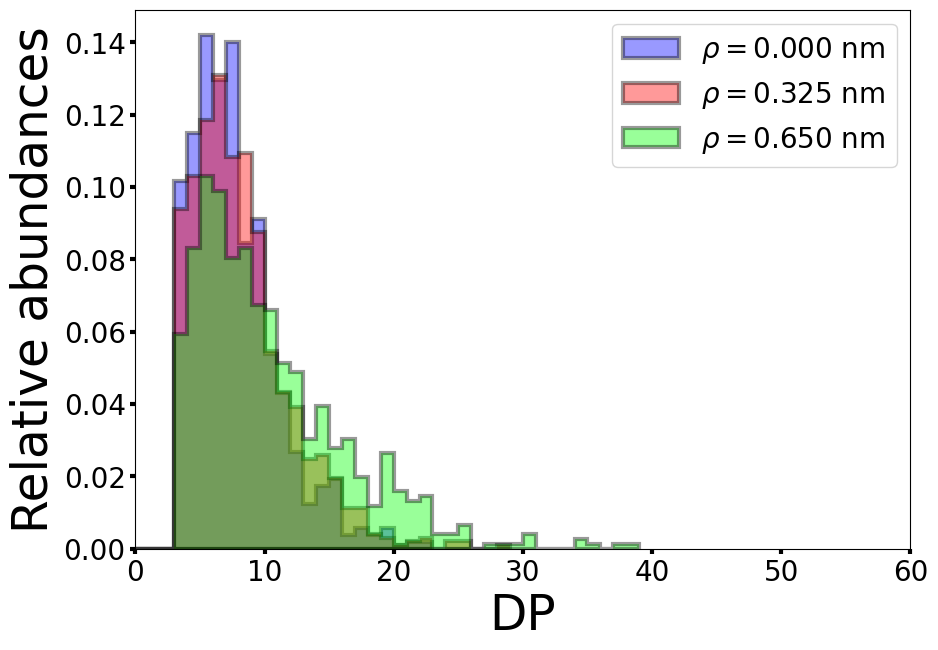

In [23]:
data1 =data_path+'/''glucose_radius_'+str(0)
data2 =data_path+'/''glucose_radius_'+str(2.7)
data3 =data_path+'/''glucose_radius_'+str(5.4)

distrib_1 = cumulative_cld(data1)
#DP, Abundance = hist_into_curve(distrib)

distrib_2 = cumulative_cld(data2)
#DP, Abundance = hist_into_curve(distrib)
distrib_3 = cumulative_cld(data3)
#DP, Abundance = hist_into_curve(distrib)

bins1 = np.linspace(0,max(distrib_1), max(distrib_1)+1)
bins2 = np.linspace(0,max(distrib_2), max(distrib_2)+1)
bins3 = np.linspace(0,max(distrib_3), max(distrib_3)+1)

figure(figsize=(10,7))

plt.hist(distrib_1,bins=bins1,histtype='stepfilled',color = 'blue', alpha=0.4, edgecolor='black', density=True ,
linewidth=3,label=r'$\rho = 0.000$ nm')
plt.hist(distrib_2,bins=bins2,histtype='stepfilled',color = 'red', alpha=0.4, edgecolor='black', density=True ,
linewidth=3,label=r'$\rho = 0.325$ nm')
plt.hist(distrib_3,bins=bins3,histtype='stepfilled',color = 'lime', alpha=0.4, edgecolor='black', density=True ,
linewidth=3,label=r'$\rho = 0.650$ nm')

plt.legend(prop={'size': 20})
plt.xlabel('DP',fontsize='35')
plt.ylabel('Relative abundances',fontsize='35')
plt.tick_params(axis='both',width=3,labelsize=20)
plt.xlim([0,60])
plt.show() 